In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.utils import np_utils
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', 50)


In [2]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# Load the spaCy language model for European Portuguese
#nlp = Portuguese()

In [3]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check

In [4]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [5]:
check(df)

,column,dtypes,nunique,sum_null
0,Text,object,52283,0
1,Source,object,3101,13003
2,URL,object,63235,0
3,Label,int64,2,0
4,text_preprocessed,object,52246,0
5,count_words_text,int64,1459,0
6,num_nouns_text,int64,530,0
7,num_verbs_text,int64,408,0
8,num_adj_text,int64,311,0
9,num_adv_text,int64,153,0


Grid Search with TF-IDF and BoW

In [6]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['features'])

# Bag of Words Vectorization
bow_vectorizer = CountVectorizer()
bow_vectors = bow_vectorizer.fit_transform(df['features'])

# Normalize BoW representation
bow_normalized = normalize(bow_vectors, norm='max', axis=1)

# Combine representations
combined_vectors = tfidf_vectors + bow_normalized

Split the Data into training and testing datasets

In [7]:
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(combined_vectors, y, test_size=0.2, random_state=42)

In [8]:
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

Grid Search of Decision Trees

In [10]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7, None],  # Number of features to consider at each split
    'ccp_alpha': [0.0, 0.01, 0.02],
    'splitter': ['best', 'random']
}

In [11]:
# Grid search for Decision Trees
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=param_grid_dt,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Perform grid search for Decision Trees
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.01, 0.02],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.7,
                                          None],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='f1_macro', verbose=1)

In [12]:
grid_search_dt_score_df = pd.DataFrame(grid_search_dt.cv_results_)
grid_search_dt_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.343299,1.288912,0.158000,0.003271,0.0,gini,None,auto,1,2,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.820510,0.815080,0.810970,0.838959,0.800029,0.817110,0.012826,2921
1,13.714597,1.209331,0.167100,0.011052,0.0,gini,None,auto,1,2,random,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.789187,0.794910,0.795706,0.794900,0.801913,0.795323,0.004039,3120
2,8.945499,1.263156,0.171801,0.021290,0.0,gini,None,auto,1,5,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.808868,0.820594,0.806426,0.847111,0.812677,0.819135,0.014788,2876
3,11.675200,1.275959,0.157199,0.013736,0.0,gini,None,auto,1,5,random,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.783224,0.805391,0.797093,0.796181,0.810616,0.798501,0.009327,3101
4,7.386797,0.763301,0.150200,0.013757,0.0,gini,None,auto,1,10,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.820809,0.811003,0.816352,0.840163,0.798830,0.817431,0.013540,2917


In [13]:
grid_search_dt_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
354,32.902300,2.806702,0.152100,0.016871,0.0,gini,10,None,1,5,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.945835,0.948491,0.947017,0.948191,0.946915,0.947290,0.000958,1
516,66.313599,6.443932,0.146100,0.016339,0.0,gini,20,0.7,1,10,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.946918,0.944846,0.948999,0.948005,0.947604,0.947274,0.001388,2
352,31.242400,2.429300,0.143699,0.008859,0.0,gini,10,None,1,2,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.945835,0.948590,0.947116,0.947992,0.946816,0.947270,0.000954,3
1510,37.012899,3.324056,0.141700,0.004262,0.0,entropy,10,None,1,20,best,"{'ccp_alpha': 0.0, 'criterion': 'entropy', 'ma...",0.946528,0.946324,0.947410,0.949075,0.946912,0.947250,0.000985,4
356,29.522900,1.328237,0.148700,0.012456,0.0,gini,10,None,1,10,best,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",0.945835,0.947997,0.947411,0.947993,0.946915,0.947230,0.000806,5


In [14]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [15]:
dt_best = grid_search_dt.best_estimator_

Decision Trees:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6285
           1       0.96      0.93      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



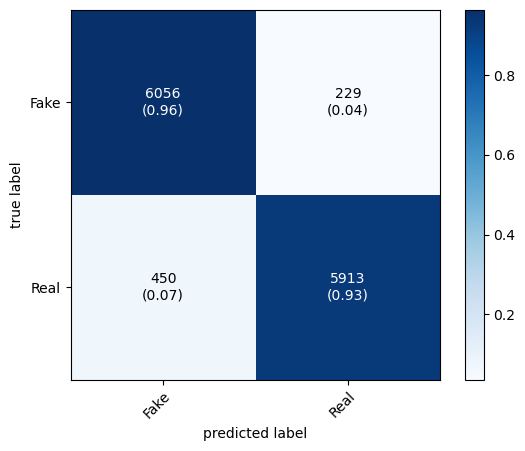

In [16]:
dt_report = classification_report(y_test, dt_best.predict(X_test))
accuracy = accuracy_score(y_test, dt_best.predict(X_test))

print("Decision Trees:")
print(dt_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, dt_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, dt_best.predict(X_test), average='macro')

results_df.loc[0] = ['Decision Trees',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [17]:
top_5_dt_df = grid_search_dt_score_df.nlargest(5,"mean_test_score")
top_5_dt_df.to_csv("Grid Search Decision Trees BoW TFIDF.csv")
print(top_5_dt_df)

      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
354       32.902300      2.806702         0.152100        0.016871   
516       66.313599      6.443932         0.146100        0.016339   
352       31.242400      2.429300         0.143699        0.008859   
1510      37.012899      3.324056         0.141700        0.004262   
356       29.522900      1.328237         0.148700        0.012456   

     param_ccp_alpha param_criterion param_max_depth param_max_features  \
354              0.0            gini              10               None   
516              0.0            gini              20                0.7   
352              0.0            gini              10               None   
1510             0.0         entropy              10               None   
356              0.0            gini              10               None   

     param_min_samples_leaf param_min_samples_split param_splitter  \
354                       1                       5       

Grid search of Random Forest

In [18]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [19]:
# Grid search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                               param_grid=param_grid_rf,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Perform grid search for Random Forest
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [ ]:
grid_search_rf_score_df = pd.DataFrame(grid_search_rf.cv_results_)
grid_search_rf_score_df.head()

In [ ]:
grid_search_rf_score_df.nlargest(5,"mean_test_score")

In [ ]:
grid_search_rf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
rf_best = grid_search_rf.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.95      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



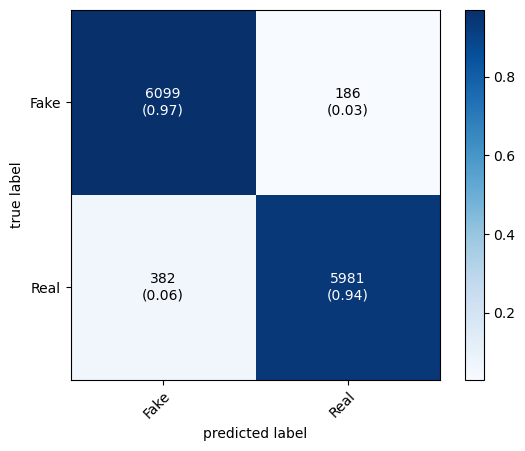

In [ ]:
rf_report = classification_report(y_test, rf_best.predict(X_test))
accuracy = accuracy_score(y_test, rf_best.predict(X_test))

print("Random Forest:")
print(rf_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, rf_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, rf_best.predict(X_test), average='macro')

results_df.loc[1] = ['Random Forest',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
top_5_rf_df = grid_search_rf_score_df.nlargest(5,"mean_test_score")
top_5_rf_df.to_csv("Grid Search Random Forest BoW TFIDF.csv")
print(top_5_rf_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80     3154.711726     11.317353         2.422495        0.429761   
242    2287.869692     46.832691         0.482542        0.084436   
159    3344.817043     35.220130         2.003323        0.361909   
232    2250.293040     21.858113         1.667836        0.384484   
78     3105.553500     34.883651         2.702822        0.633852   

    param_colsample_bytree param_learning_rate param_max_depth  \
80                     0.8                 0.2               5   
242                    1.0                 0.2               5   
159                    0.9                 0.2               5   
232                    1.0                 0.2               4   
78                     0.8                 0.2               5   

    param_n_estimators param_subsample  \
80                 300             1.0   
242                300             1.0   
159                300             0.8   
232                3

In [ ]:
results_df.to_csv("Grid Search text only results.csv", index=False)

Grid search of Extra Trees (Took too long)

In [ ]:
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [ ]:
# Grid search for Extra Trees
grid_search_et = GridSearchCV(ExtraTreesClassifier(random_state=42),
                               param_grid=param_grid_et,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Perform grid search for Extra Trees
grid_search_et.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


In [ ]:
grid_search_et_score_df = pd.DataFrame(grid_search_et.cv_results_)
grid_search_et_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,959.933681,14.291768,3.621716,2.022817,0.8,0.01,3,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920912,0.923074,0.927634,0.921996,0.921167,0.922957,0.002458,241
1,976.555191,19.696976,3.227154,1.131643,0.8,0.01,3,100,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920912,0.923074,0.924684,0.921996,0.921167,0.922367,0.001383,243
2,997.083520,20.974425,3.466188,0.724088,0.8,0.01,3,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.921009,0.925429,0.926456,0.924741,0.920969,0.923721,0.002296,236
3,1896.742218,31.435744,2.843839,0.703938,0.8,0.01,3,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925037,0.926118,0.928029,0.925427,0.925001,0.925923,0.001128,227
4,1921.956441,27.029407,5.153854,2.876813,0.8,0.01,3,200,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925234,0.926018,0.927931,0.925427,0.924901,0.925902,0.001078,228


In [ ]:
grid_search_et_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
80,3154.711726,11.317353,2.422495,0.429761,0.8,0.2,5,300,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.957099,0.957689,0.955917,0.956502,0.955908,0.956623,0.000691,1
242,2287.869692,46.832691,0.482542,0.084436,1.0,0.2,5,300,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.957296,0.958184,0.955223,0.955413,0.956105,0.956444,0.001134,2
159,3344.817043,35.220130,2.003323,0.361909,0.9,0.2,5,300,0.8,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.957398,0.957395,0.955820,0.954821,0.955316,0.956150,0.001066,3
232,2250.293040,21.858113,1.667836,0.384484,1.0,0.2,4,300,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.956406,0.955416,0.955718,0.956996,0.956008,0.956109,0.000551,4
78,3105.553500,34.883651,2.702822,0.633852,0.8,0.2,5,300,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.957298,0.956506,0.955325,0.955613,0.955712,0.956091,0.000719,5


In [ ]:
grid_search_et.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
et_best = grid_search_et.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.95      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



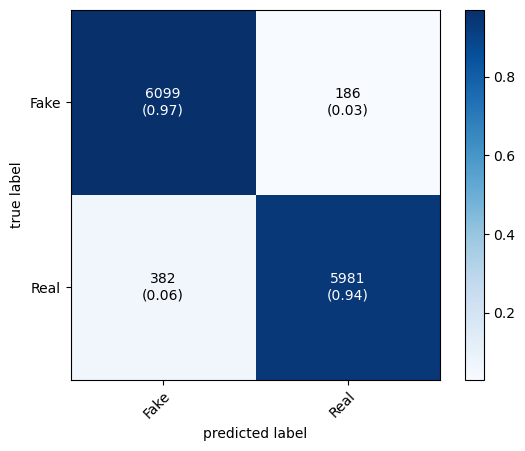

In [ ]:
et_report = classification_report(y_test, et_best.predict(X_test))
accuracy = accuracy_score(y_test, et_best.predict(X_test))

print("Extra Trees:")
print(et_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, et_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, et_best.predict(X_test), average='macro')

results_df.loc[2] = ['Extra Trees',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
top_5_et_df = grid_search_et_score_df.nlargest(5,"mean_test_score")
top_5_et_df.to_csv("Grid Search Extra Trees BoW TFIDF.csv")
print(top_5_et_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80     3154.711726     11.317353         2.422495        0.429761   
242    2287.869692     46.832691         0.482542        0.084436   
159    3344.817043     35.220130         2.003323        0.361909   
232    2250.293040     21.858113         1.667836        0.384484   
78     3105.553500     34.883651         2.702822        0.633852   

    param_colsample_bytree param_learning_rate param_max_depth  \
80                     0.8                 0.2               5   
242                    1.0                 0.2               5   
159                    0.9                 0.2               5   
232                    1.0                 0.2               4   
78                     0.8                 0.2               5   

    param_n_estimators param_subsample  \
80                 300             1.0   
242                300             1.0   
159                300             0.8   
232                3

Grid search of XGBoost

In [9]:
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting trees
}

In [10]:
# Grid search for Decision Trees
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42),
                               param_grid=param_grid_xgb,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Decision Trees
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=6,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

In [11]:
grid_search_xgb_score_df = pd.DataFrame(grid_search_xgb.cv_results_)
grid_search_xgb_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.302257,0.265606,0.051344,0.004788,0.8,0.01,3,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920299,0.922580,0.923999,0.920705,0.919970,0.921511,0.001538,243
1,47.757773,0.366760,0.047401,0.004500,0.8,0.01,3,100,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.919999,0.923071,0.924191,0.920705,0.919970,0.921587,0.001726,241
2,48.343110,1.333837,0.040864,0.005603,0.8,0.01,3,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920295,0.922874,0.923799,0.920800,0.919872,0.921528,0.001534,242
3,83.213096,0.368801,0.051961,0.003068,0.8,0.01,3,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925535,0.926232,0.928341,0.925435,0.924713,0.926051,0.001242,216
4,88.590352,0.473333,0.054728,0.004809,0.8,0.01,3,200,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925437,0.926132,0.928538,0.924945,0.924713,0.925953,0.001381,226


In [12]:
grid_search_xgb_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
79,166.373995,0.764300,0.081862,0.016657,0.8,0.2,5,300,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.956112,0.955121,0.957399,0.955510,0.956107,0.956050,0.000772,1
241,211.965514,1.974762,0.081186,0.007070,1.0,0.2,5,300,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.955219,0.955812,0.958188,0.955609,0.955216,0.956009,0.001113,2
160,187.763778,1.959260,0.081301,0.012048,0.9,0.2,5,300,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.958088,0.954726,0.955816,0.956895,0.953831,0.955871,0.001513,3
151,156.317612,0.827699,0.070331,0.010947,0.9,0.2,4,300,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.956704,0.955218,0.957397,0.954424,0.955511,0.955851,0.001065,4
231,161.190095,0.931295,0.077458,0.004173,1.0,0.2,4,300,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.955024,0.954825,0.956114,0.956502,0.956006,0.955694,0.000653,5


In [13]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [14]:
xgb_best = grid_search_xgb.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.96      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



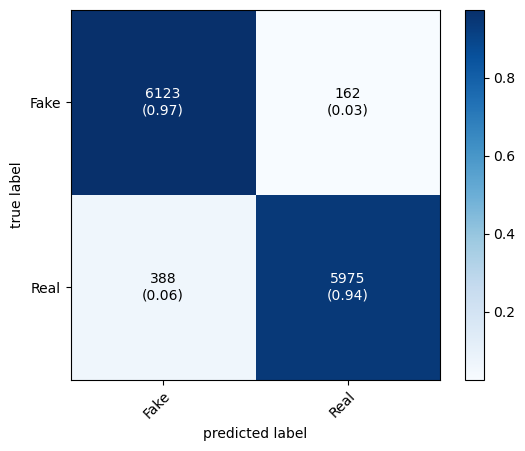

In [15]:
xgb_report = classification_report(y_test, xgb_best.predict(X_test))
accuracy = accuracy_score(y_test, xgb_best.predict(X_test))

print("XGBoost:")
print(xgb_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, xgb_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, xgb_best.predict(X_test), average='macro')

results_df.loc[3] = ['XGBoost',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [16]:
top_5_xlgb_df = grid_search_xgb_score_df.nlargest(5,"mean_test_score")
top_5_xlgb_df.to_csv("Grid Search XGBoost BoW TFIDF.csv")
print(top_5_xlgb_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
79      166.373995      0.764300         0.081862        0.016657   
241     211.965514      1.974762         0.081186        0.007070   
160     187.763778      1.959260         0.081301        0.012048   
151     156.317612      0.827699         0.070331        0.010947   
231     161.190095      0.931295         0.077458        0.004173   

    param_colsample_bytree param_learning_rate param_max_depth  \
79                     0.8                 0.2               5   
241                    1.0                 0.2               5   
160                    0.9                 0.2               5   
151                    0.9                 0.2               4   
231                    1.0                 0.2               4   

    param_n_estimators param_subsample  \
79                 300             0.9   
241                300             0.9   
160                300             0.9   
151                3

Grid search of Adaboost (Took too long)

In [17]:
param_grid_ada = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
}

In [18]:
# Grid search for Adaboost
grid_search_ada = GridSearchCV(AdaBoostClassifier(random_state=42),
                               param_grid=param_grid_ada,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Adaboost
grid_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1_macro', verbose=1)

In [19]:
grid_search_ada_score_df = pd.DataFrame(grid_search_ada.cv_results_)
grid_search_ada_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,263.732643,3.815012,0.949197,0.162779,0.01,50,"{'learning_rate': 0.01, 'n_estimators': 50}",0.697580,0.709316,0.710068,0.713043,0.708860,0.707773,0.005301,20
1,489.729404,12.483964,1.478926,0.317669,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.820645,0.816437,0.814393,0.827850,0.816076,0.819080,0.004845,19
2,955.064637,14.356525,2.759734,0.172141,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.851295,0.877546,0.883895,0.856093,0.878340,0.869434,0.013124,18
3,1397.721602,26.896462,3.874309,0.246341,0.01,300,"{'learning_rate': 0.01, 'n_estimators': 300}",0.895776,0.900543,0.902357,0.901045,0.899700,0.899884,0.002227,17
4,232.874321,6.450991,0.670911,0.023037,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.915731,0.918693,0.921779,0.918787,0.920345,0.919067,0.002017,16


In [20]:
grid_search_ada_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,1464.327343,29.573034,4.484839,0.255611,0.5,300,"{'learning_rate': 0.5, 'n_estimators': 300}",0.947415,0.946028,0.948010,0.947407,0.946611,0.947094,0.000694,1
14,904.574300,14.019749,3.009517,0.272076,0.5,200,"{'learning_rate': 0.5, 'n_estimators': 200}",0.945044,0.943851,0.946523,0.945627,0.943840,0.944977,0.001037,2
19,1431.669064,33.585735,3.591514,0.496509,1.0,300,"{'learning_rate': 1.0, 'n_estimators': 300}",0.945641,0.944850,0.945839,0.945635,0.942174,0.944828,0.001370,3
18,966.494403,29.599116,2.872607,0.147544,1.0,200,"{'learning_rate': 1.0, 'n_estimators': 200}",0.943961,0.942675,0.944653,0.944548,0.941184,0.943404,0.001314,4
11,1367.056451,20.730093,3.863792,0.198841,0.2,300,"{'learning_rate': 0.2, 'n_estimators': 300}",0.939793,0.941561,0.943545,0.943142,0.941847,0.941978,0.001325,5


In [21]:
grid_search_ada.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=300, random_state=42)

In [22]:
ada_best = grid_search_ada.best_estimator_

Adaboost:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6285
           1       0.96      0.93      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



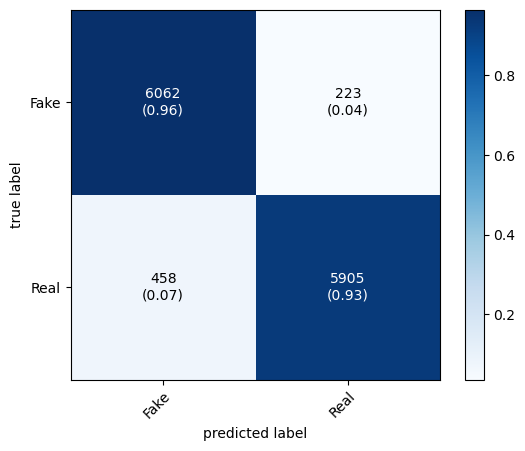

In [23]:
ada_report = classification_report(y_test, ada_best.predict(X_test))
accuracy = accuracy_score(y_test, ada_best.predict(X_test))

print("Adaboost:")
print(ada_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, ada_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, ada_best.predict(X_test), average='macro')

results_df.loc[4] = ['Adaboost',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [24]:
top_5_ada_df = grid_search_ada_score_df.nlargest(5,"mean_test_score")
top_5_ada_df.to_csv("Grid Search Adaboost BoW TFIDF.csv")
print(top_5_ada_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15    1464.327343     29.573034         4.484839        0.255611   
14     904.574300     14.019749         3.009517        0.272076   
19    1431.669064     33.585735         3.591514        0.496509   
18     966.494403     29.599116         2.872607        0.147544   
11    1367.056451     20.730093         3.863792        0.198841   

   param_learning_rate param_n_estimators  \
15                 0.5                300   
14                 0.5                200   
19                 1.0                300   
18                 1.0                200   
11                 0.2                300   

                                         params  split0_test_score  \
15  {'learning_rate': 0.5, 'n_estimators': 300}           0.947415   
14  {'learning_rate': 0.5, 'n_estimators': 200}           0.945044   
19  {'learning_rate': 1.0, 'n_estimators': 300}           0.945641   
18  {'learning_rate': 1.0, 'n_estimators

Grid search of Gradient Boosting

In [41]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
}

In [42]:
# Grid search for Gradient Boosting
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42),
                               param_grid=param_grid_gb,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Gradient Boosting
grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


In [ ]:
grid_search_gb_score_df = pd.DataFrame(grid_search_gb.cv_results_)
grid_search_gb_score_df.head()

In [ ]:
grid_search_gb_score_df.nlargest(5,"mean_test_score")

In [ ]:
grid_search_gb.best_estimator_

In [ ]:
gb_best = grid_search_gb.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.95      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



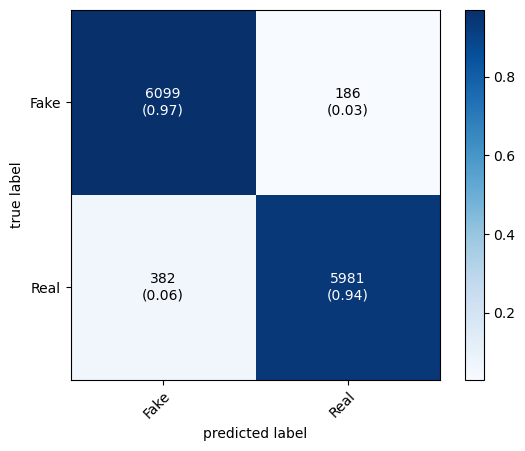

In [ ]:
gb_report = classification_report(y_test, gb_best.predict(X_test))
accuracy = accuracy_score(y_test, gb_best.predict(X_test))

print("Gradient Boosting:")
print(gb_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, gb_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, gb_best.predict(X_test), average='macro')

results_df.loc[5] = ['Gradient Boosting',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
top_5_gb_df = grid_search_gb_score_df.nlargest(5,"mean_test_score")
top_5_gb_df.to_csv("Grid Search Gradient Boosting BoW TFIDF.csv")
print(top_5_gb_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80     3154.711726     11.317353         2.422495        0.429761   
242    2287.869692     46.832691         0.482542        0.084436   
159    3344.817043     35.220130         2.003323        0.361909   
232    2250.293040     21.858113         1.667836        0.384484   
78     3105.553500     34.883651         2.702822        0.633852   

    param_colsample_bytree param_learning_rate param_max_depth  \
80                     0.8                 0.2               5   
242                    1.0                 0.2               5   
159                    0.9                 0.2               5   
232                    1.0                 0.2               4   
78                     0.8                 0.2               5   

    param_n_estimators param_subsample  \
80                 300             1.0   
242                300             1.0   
159                300             0.8   
232                3

Grid search of Bagging (Took too long)

In [ ]:
param_grid_bag = {
    'n_estimators': [10, 50, 100],  # Number of base estimators (trees)
    'bootstrap': [True, False],    # Whether to use bootstrapping
    'max_samples': [0.5, 0.7, 0.9, 1.0],  # Fraction of samples used for training each base estimator
}

In [ ]:
# Grid search for Bagging
grid_search_bag = GridSearchCV(BaggingClassifier(random_state=42),
                               param_grid=param_grid_bag,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Bagging
grid_search_bag.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
grid_search_bag_score_df = pd.DataFrame(grid_search_bag.cv_results_)
grid_search_bag_score_df.head()

In [ ]:
grid_search_bag_score_df.nlargest(5,"mean_test_score")

In [ ]:
grid_search_bag.best_estimator_

In [ ]:
bag_best = grid_search_bag.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.95      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



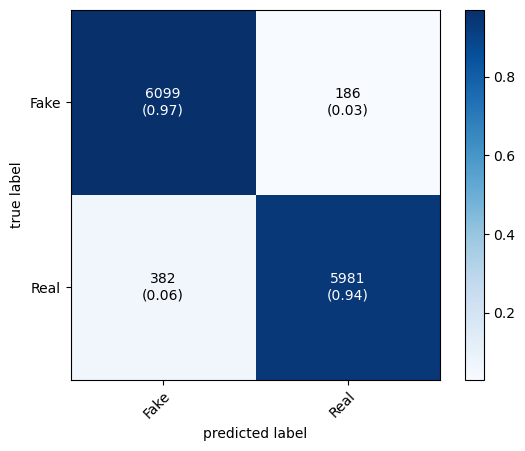

In [ ]:
bag_report = classification_report(y_test, bag_best.predict(X_test))
accuracy = accuracy_score(y_test, bag_best.predict(X_test))

print("Bagging:")
print(bag_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, bag_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, bag_best.predict(X_test), average='macro')

results_df.loc[6] = ['Bagging',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
top_5_bag_df = grid_search_bag_score_df.nlargest(5,"mean_test_score")
top_5_bag_df.to_csv("Grid Search Bagging BoW TFIDF.csv")
print(top_5_bag_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80     3154.711726     11.317353         2.422495        0.429761   
242    2287.869692     46.832691         0.482542        0.084436   
159    3344.817043     35.220130         2.003323        0.361909   
232    2250.293040     21.858113         1.667836        0.384484   
78     3105.553500     34.883651         2.702822        0.633852   

    param_colsample_bytree param_learning_rate param_max_depth  \
80                     0.8                 0.2               5   
242                    1.0                 0.2               5   
159                    0.9                 0.2               5   
232                    1.0                 0.2               4   
78                     0.8                 0.2               5   

    param_n_estimators param_subsample  \
80                 300             1.0   
242                300             1.0   
159                300             0.8   
232                3

Grid search of Logistic Regression (CONTINUE HERE)

In [25]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Type of penalty (L1 or L2)
    'max_iter': [100, 300, 500],  # Maximum number of iterations
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use in optimization
}

In [26]:
# Grid search for Decision Trees
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=param_grid_lr,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Decision Trees
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packa

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 300, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='f1_macro', verbose=1)

In [27]:
grid_search_lr_score_df = pd.DataFrame(grid_search_lr.cv_results_)
grid_search_lr_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.919359,0.045934,0.021878,0.007654,0.01,100,l1,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.900495,0.894794,0.898472,0.902012,0.896740,0.898502,0.002575,70
1,0.186341,0.059578,0.000000,0.000000,0.01,100,l1,lbfgs,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
2,10.334624,0.555787,0.016034,0.003542,0.01,100,l1,saga,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.899495,0.893487,0.898355,0.900212,0.896327,0.897575,0.002430,73
3,2.035378,0.282852,0.013604,0.004072,0.01,100,l2,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.913222,0.913617,0.913421,0.908564,0.906489,0.911062,0.002963,61
4,2.571440,0.417917,0.018504,0.004178,0.01,100,l2,lbfgs,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.912628,0.913120,0.913321,0.907770,0.906388,0.910646,0.002953,67


In [28]:
grid_search_lr_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,4.461224,0.473694,0.020078,0.008000,1,100,l1,liblinear,"{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...",0.948310,0.944257,0.944950,0.947118,0.943065,0.945540,0.001912,1
42,4.160945,0.861488,0.018370,0.004671,1,300,l1,liblinear,"{'C': 1, 'max_iter': 300, 'penalty': 'l1', 'so...",0.948310,0.944257,0.944950,0.947118,0.943065,0.945540,0.001912,1
48,4.268571,0.585185,0.011130,0.000920,1,500,l1,liblinear,"{'C': 1, 'max_iter': 500, 'penalty': 'l1', 'so...",0.948310,0.944257,0.944950,0.947118,0.943065,0.945540,0.001912,1
44,155.081694,4.059181,0.013377,0.003880,1,300,l1,saga,"{'C': 1, 'max_iter': 300, 'penalty': 'l1', 'so...",0.948408,0.943663,0.944653,0.946821,0.943064,0.945322,0.002003,4
50,218.195165,2.913660,0.009882,0.001161,1,500,l1,saga,"{'C': 1, 'max_iter': 500, 'penalty': 'l1', 'so...",0.948112,0.943861,0.944752,0.946920,0.942768,0.945283,0.001965,5


In [29]:
grid_search_lr.best_estimator_

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [30]:
lr_best = grid_search_lr.best_estimator_

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6285
           1       0.96      0.94      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



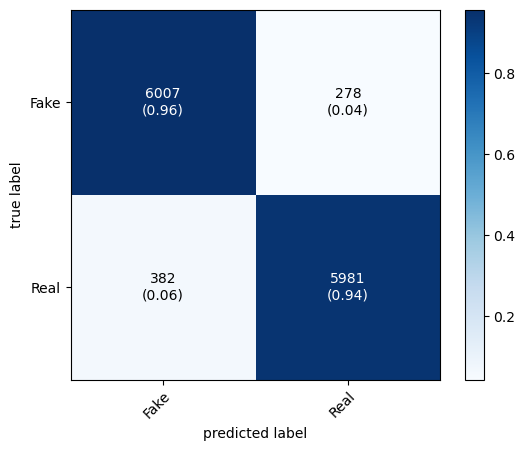

In [31]:
lr_report = classification_report(y_test, lr_best.predict(X_test))
accuracy = accuracy_score(y_test, lr_best.predict(X_test))

print("Logistic Regression:")
print(lr_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, lr_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, lr_best.predict(X_test), average='macro')

results_df.loc[7] = ['Logistic Regression',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [32]:
top_5_lr_df = grid_search_lr_score_df.nlargest(5,"mean_test_score")
top_5_lr_df.to_csv("Grid Search Logistic Regression BoW TFIDF.csv")
print(top_5_lr_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
36       4.461224      0.473694         0.020078        0.008000       1   
42       4.160945      0.861488         0.018370        0.004671       1   
48       4.268571      0.585185         0.011130        0.000920       1   
44     155.081694      4.059181         0.013377        0.003880       1   
50     218.195165      2.913660         0.009882        0.001161       1   

   param_max_iter param_penalty param_solver  \
36            100            l1    liblinear   
42            300            l1    liblinear   
48            500            l1    liblinear   
44            300            l1         saga   
50            500            l1         saga   

                                               params  split0_test_score  \
36  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...           0.948310   
42  {'C': 1, 'max_iter': 300, 'penalty': 'l1', 'so...           0.948310   
48  {'C': 1, 'max_iter': 5

Grid search of Linear SVC

In [33]:
param_grid_lsvc = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'],
    'max_iter': [700, 1000, 1300],
    'dual': [True, False]
}

In [34]:
# Grid search for Decision Trees
grid_search_lsvc = GridSearchCV(LinearSVC(random_state=42),
                               param_grid=param_grid_lsvc,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Decision Trees
grid_search_lsvc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\svm\_

GridSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'dual': [True, False],
                         'max_iter': [700, 1000, 1300],
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=1)

In [35]:
grid_search_lsvc_score_df = pd.DataFrame(grid_search_lsvc.cv_results_)
grid_search_lsvc_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.108113,0.011495,0.000000,0.000000,0.01,True,700,l1,"{'C': 0.01, 'dual': True, 'max_iter': 700, 'pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
1,0.873381,0.058974,0.014160,0.002785,0.01,True,700,l2,"{'C': 0.01, 'dual': True, 'max_iter': 700, 'pe...",0.945637,0.944351,0.941784,0.941083,0.941281,0.942827,0.001829,13
2,0.125926,0.004546,0.000000,0.000000,0.01,True,1000,l1,"{'C': 0.01, 'dual': True, 'max_iter': 1000, 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
3,0.957263,0.158469,0.012365,0.003230,0.01,True,1000,l2,"{'C': 0.01, 'dual': True, 'max_iter': 1000, 'p...",0.945637,0.944351,0.941784,0.941083,0.941281,0.942827,0.001829,13
4,0.074733,0.015868,0.000000,0.000000,0.01,True,1300,l1,"{'C': 0.01, 'dual': True, 'max_iter': 1300, 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46


In [36]:
grid_search_lsvc_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,16.524659,7.624908,0.015178,0.003681,0.1,False,700,l2,"{'C': 0.1, 'dual': False, 'max_iter': 700, 'pe...",0.948112,0.946727,0.945839,0.946227,0.944745,0.94633,0.001104,1
21,18.056764,7.923784,0.015936,0.002737,0.1,False,1000,l2,"{'C': 0.1, 'dual': False, 'max_iter': 1000, 'p...",0.948112,0.946727,0.945839,0.946227,0.944745,0.94633,0.001104,1
23,17.809959,7.647587,0.012928,0.001184,0.1,False,1300,l2,"{'C': 0.1, 'dual': False, 'max_iter': 1300, 'p...",0.948112,0.946727,0.945839,0.946227,0.944745,0.94633,0.001104,1
13,2.488403,0.155330,0.013544,0.000426,0.1,True,700,l2,"{'C': 0.1, 'dual': True, 'max_iter': 700, 'pen...",0.948112,0.946727,0.945740,0.946227,0.944745,0.94631,0.001114,4
15,2.271294,0.098272,0.012735,0.000990,0.1,True,1000,l2,"{'C': 0.1, 'dual': True, 'max_iter': 1000, 'pe...",0.948112,0.946727,0.945740,0.946227,0.944745,0.94631,0.001114,4


In [37]:
grid_search_lsvc.best_estimator_

LinearSVC(C=0.1, dual=False, max_iter=700, random_state=42)

In [38]:
lsvc_best = grid_search_lsvc.best_estimator_

Linear SVC:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      6285
           1       0.95      0.94      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



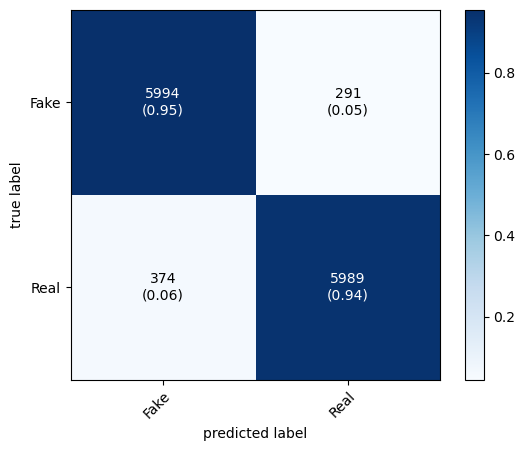

In [39]:
lsvc_report = classification_report(y_test, lsvc_best.predict(X_test))
accuracy = accuracy_score(y_test, lsvc_best.predict(X_test))

print("Linear SVC:")
print(lsvc_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, lsvc_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, lsvc_best.predict(X_test), average='macro')

results_df.loc[8] = ['Linear SVC',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [40]:
top_5_lsvc_df = grid_search_lsvc_score_df.nlargest(5,"mean_test_score")
top_5_lsvc_df.to_csv("Grid Search Linear SVC BoW TFIDF.csv")
print(top_5_lsvc_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
19      16.524659      7.624908         0.015178        0.003681     0.1   
21      18.056764      7.923784         0.015936        0.002737     0.1   
23      17.809959      7.647587         0.012928        0.001184     0.1   
13       2.488403      0.155330         0.013544        0.000426     0.1   
15       2.271294      0.098272         0.012735        0.000990     0.1   

   param_dual param_max_iter param_penalty  \
19      False            700            l2   
21      False           1000            l2   
23      False           1300            l2   
13       True            700            l2   
15       True           1000            l2   

                                               params  split0_test_score  \
19  {'C': 0.1, 'dual': False, 'max_iter': 700, 'pe...           0.948112   
21  {'C': 0.1, 'dual': False, 'max_iter': 1000, 'p...           0.948112   
23  {'C': 0.1, 'dual': False, 'max_ite

In [ ]:
results_df.to_csv("Grid Search results BoW TFIDF.csv", index=False)